<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Barplots-per-patient" data-toc-modified-id="Barplots-per-patient-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Barplots per patient</a></span></li><li><span><a href="#Target-identification-analysis-on-mapped-Petti-data" data-toc-modified-id="Target-identification-analysis-on-mapped-Petti-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Target identification analysis on mapped Petti data</a></span><ul class="toc-item"><li><span><a href="#Differential-expression" data-toc-modified-id="Differential-expression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Differential expression</a></span><ul class="toc-item"><li><span><a href="#HSC" data-toc-modified-id="HSC-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>HSC</a></span></li><li><span><a href="#Prog" data-toc-modified-id="Prog-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Prog</a></span></li></ul></li><li><span><a href="#Filter-genes-according-to-surface-and-T-cell-expression" data-toc-modified-id="Filter-genes-according-to-surface-and-T-cell-expression-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Filter genes according to surface and T cell expression</a></span></li><li><span><a href="#Filter-according-to-CrossOrganAtlas-and-druggable-genes" data-toc-modified-id="Filter-according-to-CrossOrganAtlas-and-druggable-genes-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Filter according to CrossOrganAtlas and druggable genes</a></span></li></ul></li></ul></div>

The notebook reproduces the subsequent analysis of mapped of AML samples from Petti et al and the main figures from the corresponding paper.

First we import required packages:

In [7]:
#pip install scanpy --upgrade

In [9]:
#pip install anndata --upgrade

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

from gprofiler import gprofiler

import warnings
from rpy2.rinterface import RRuntimeWarning
from rpy2.robjects import pandas2ri

%load_ext rpy2.ipython

warnings.filterwarnings("ignore", category=RRuntimeWarning)
pandas2ri.activate()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
sc.settings.verbosity = 3
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         8.4.0
anyio                       NA
asciitree                   NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
backports                   NA
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      1.0.9
certifi                     2021.10.08
cffi                        1.15.0
chardet                     4.0.0
charset_normalizer          2.0.8
cloudpickle                 2.0.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
dask                        2021.11.2
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.0
defusedxml                  0.7.1
entrypoints                 0.3
fasteners                   NA
fsspec                      0.7.4
google                      NA
gprofiler                   1.0.0
h5py          

In [2]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [3]:
sc.set_figure_params(vector_friendly=True, color_map='Reds',
                     dpi=200,transparent=True, fontsize=14)

In [ ]:
# set path for data and results
writepath='path/to/data/'

# Barplots per patient

In [17]:
adata=sc.read(writepath + 'scanvi_full.h5ad')
ix=np.isin(adata.obs['dataset'],['Petti']) 
adata=adata[ix].copy()

In [18]:
adata

AnnData object with n_obs × n_vars = 78364 × 17434
    obs: 'study', 'cell_type', 'predictions', 'condition', 'batch', 'dataset', 'cell_type_final'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'cell_type_final', 'cell_type_final_colors', 'dataset_colors', 'neighbors', 'predictions', 'predictions_colors', 'study_colors', 'tsne', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [ ]:
# create obs, if cell_type ends with -like -> malignant, otherwise healthy

In [19]:
adata.obs['PredictionRefined']=adata.obs.cell_type_final.str.endswith(tuple('-like')).map({True:'malignant',False:'normal'})


In [20]:
adata.obs.PredictionRefined.value_counts()

malignant    46397
normal       31967
Name: PredictionRefined, dtype: int64

In [22]:
adata.obs.study.cat.categories

Index(['508084', '548327', '721214', '782328', '809653'], dtype='object')

In [21]:
adata.strings_to_categoricals()

... storing 'PredictionRefined' as categorical


In [70]:
adata.uns['PredictionRefined_colors']=['#FC766AFF', '#5B84B1FF']

In [23]:
df_fin=pd.DataFrame()

for patient in adata.obs.study.cat.categories:
    # subset adata
    ix=np.isin(adata.obs['study'],[patient])
    adata_tmp=adata[ix].copy()

    # get mal and nor values
    mal=np.round(len(adata_tmp[adata_tmp.obs.PredictionRefined=='malignant'].obs.index)*100/len(adata_tmp.obs.index),2)
    nor=np.round(len(adata_tmp[adata_tmp.obs.PredictionRefined=='normal'].obs.index)*100/len(adata_tmp.obs.index),2)
        
    # append to df 
    new_row = {'patient':str(patient), 'Malignant':mal, 'Normal':nor}
    df_fin = df_fin.append(new_row, ignore_index=True) 

In [27]:
df_fin.index=df_fin.patient

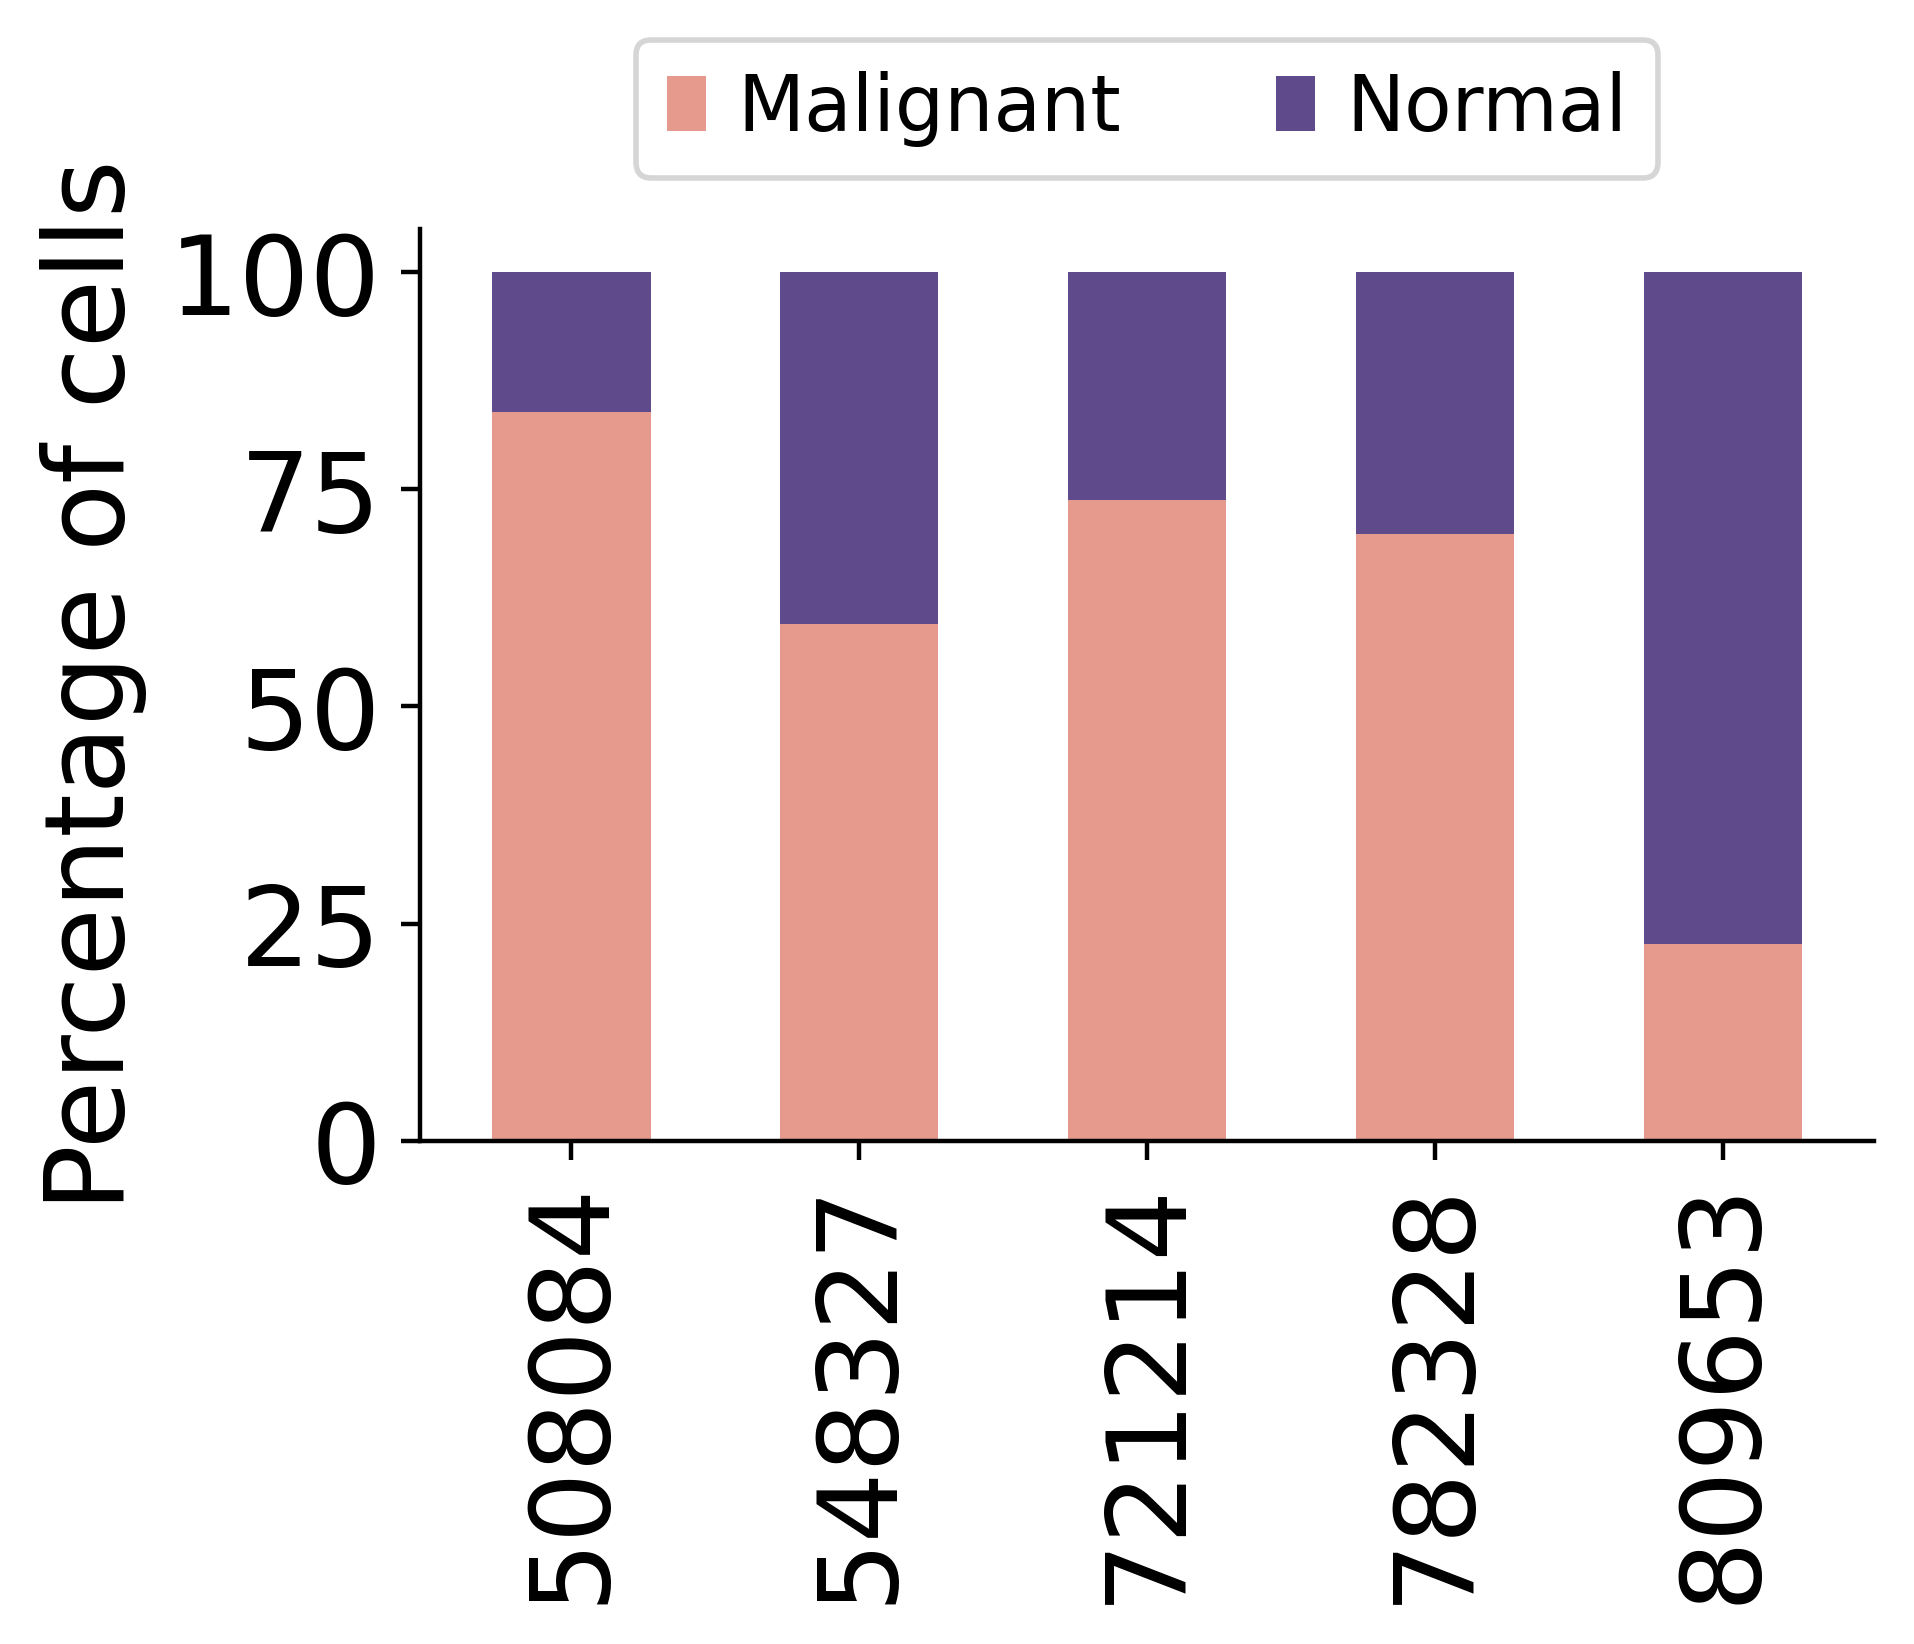

In [39]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(4.66,3))
ax=df_fin.plot(x='patient',
            kind='bar',
            width=0.55, 
               ax=ax,
            stacked=True,
            color=['#E69A8DFF','#5F4B8BFF'],
            title='')
plt.ylabel('Percentage of cells', size = 20)
plt.xlabel('', size = 20)
plt.xticks(size = 20)
plt.yticks(size = 20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid()
ax.yaxis.grid()
ax.get_legend().remove()

plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.25), ncol=2, prop={'size': 14})
#plt.tick_params(axis='x',which='both',bottom=False,top=False, labelbottom=False)

In [40]:
df_final=pd.DataFrame()
goi='CSF1R','CD86','CD33','IL3RA'

In [45]:
for patient in adata.obs.study.cat.categories:
    # subset adata to patient
    ix=np.isin(adata.obs['study'],[patient])
    adata_tmp=adata[ix].copy()
    
    for gene in goi:
        # subset adata to gene
        adata_tmp_goi=adata_tmp[:,gene].copy()
        
        # calculate how many cells express that gene
        expr=pd.DataFrame(adata_tmp_goi.X)
        expr.index=adata_tmp_goi.obs.index
        expr['PredictionRefined']=adata_tmp_goi.obs['PredictionRefined']
        expr = expr[(expr[0] > 0)]
        expr=expr.groupby('PredictionRefined').count()
        expr=expr.transpose()
        
        # calculate absoulte numbers for percentage
        absolute=pd.DataFrame(adata_tmp_goi.obs['PredictionRefined'].value_counts()).transpose()
        
        goi_mal_pct=int(expr['malignant'])*100/int(absolute['malignant'])
        goi_nor_pct=int(expr['normal'])*100/int(absolute['normal'])
        new_row = {'patient':str(patient), 'Malignant':goi_mal_pct, 'Normal':goi_nor_pct,'gene':str(gene)}
        df_final = df_final.append(new_row, ignore_index=True)

In [46]:
df_final

,Malignant,Normal,gene,patient
0,25.761288,11.339735,CSF1R,508084
1,32.822891,21.947874,CD86,508084
2,52.546377,24.919982,CD33,508084
3,45.572279,20.164609,IL3RA,508084
4,8.064218,3.575298,CSF1R,548327
5,1.291751,3.277356,CD86,548327
6,19.099465,6.825569,CD33,548327
7,8.691641,3.521127,IL3RA,548327
8,9.798955,3.069395,CSF1R,721214
9,8.967864,7.206406,CD86,721214


In [47]:
df1=df_final[df_final['gene']=='CSF1R']
df2=df_final[df_final['gene']=='CD86']
df3=df_final[df_final['gene']=='CD33']
df4=df_final[df_final['gene']=='IL3RA']

In [48]:
df1.patient=['508084','548327','721214','782328','809653']
df1.index=['508084','548327','721214','782328','809653']

df2.patient=['508084','548327','721214','782328','809653']
df2.index=['508084','548327','721214','782328','809653']

df3.patient=['508084','548327','721214','782328','809653']
df3.index=['508084','548327','721214','782328','809653']

df4.patient=['508084','548327','721214','782328','809653']
df4.index=['508084','548327','721214','782328','809653']

/opt/python/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [49]:
df1.index=df1.patient
df1=df1.loc[df_fin['patient']]

df2.index=df2.patient
df2=df2.loc[df_fin['patient']]

df3.index=df3.patient
df3=df3.loc[df_fin['patient']]

df4.index=df4.patient
df4=df4.loc[df_fin['patient']]

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '508084'),
  Text(1, 0, '548327'),
  Text(2, 0, '721214'),
  Text(3, 0, '782328'),
  Text(4, 0, '809653')])

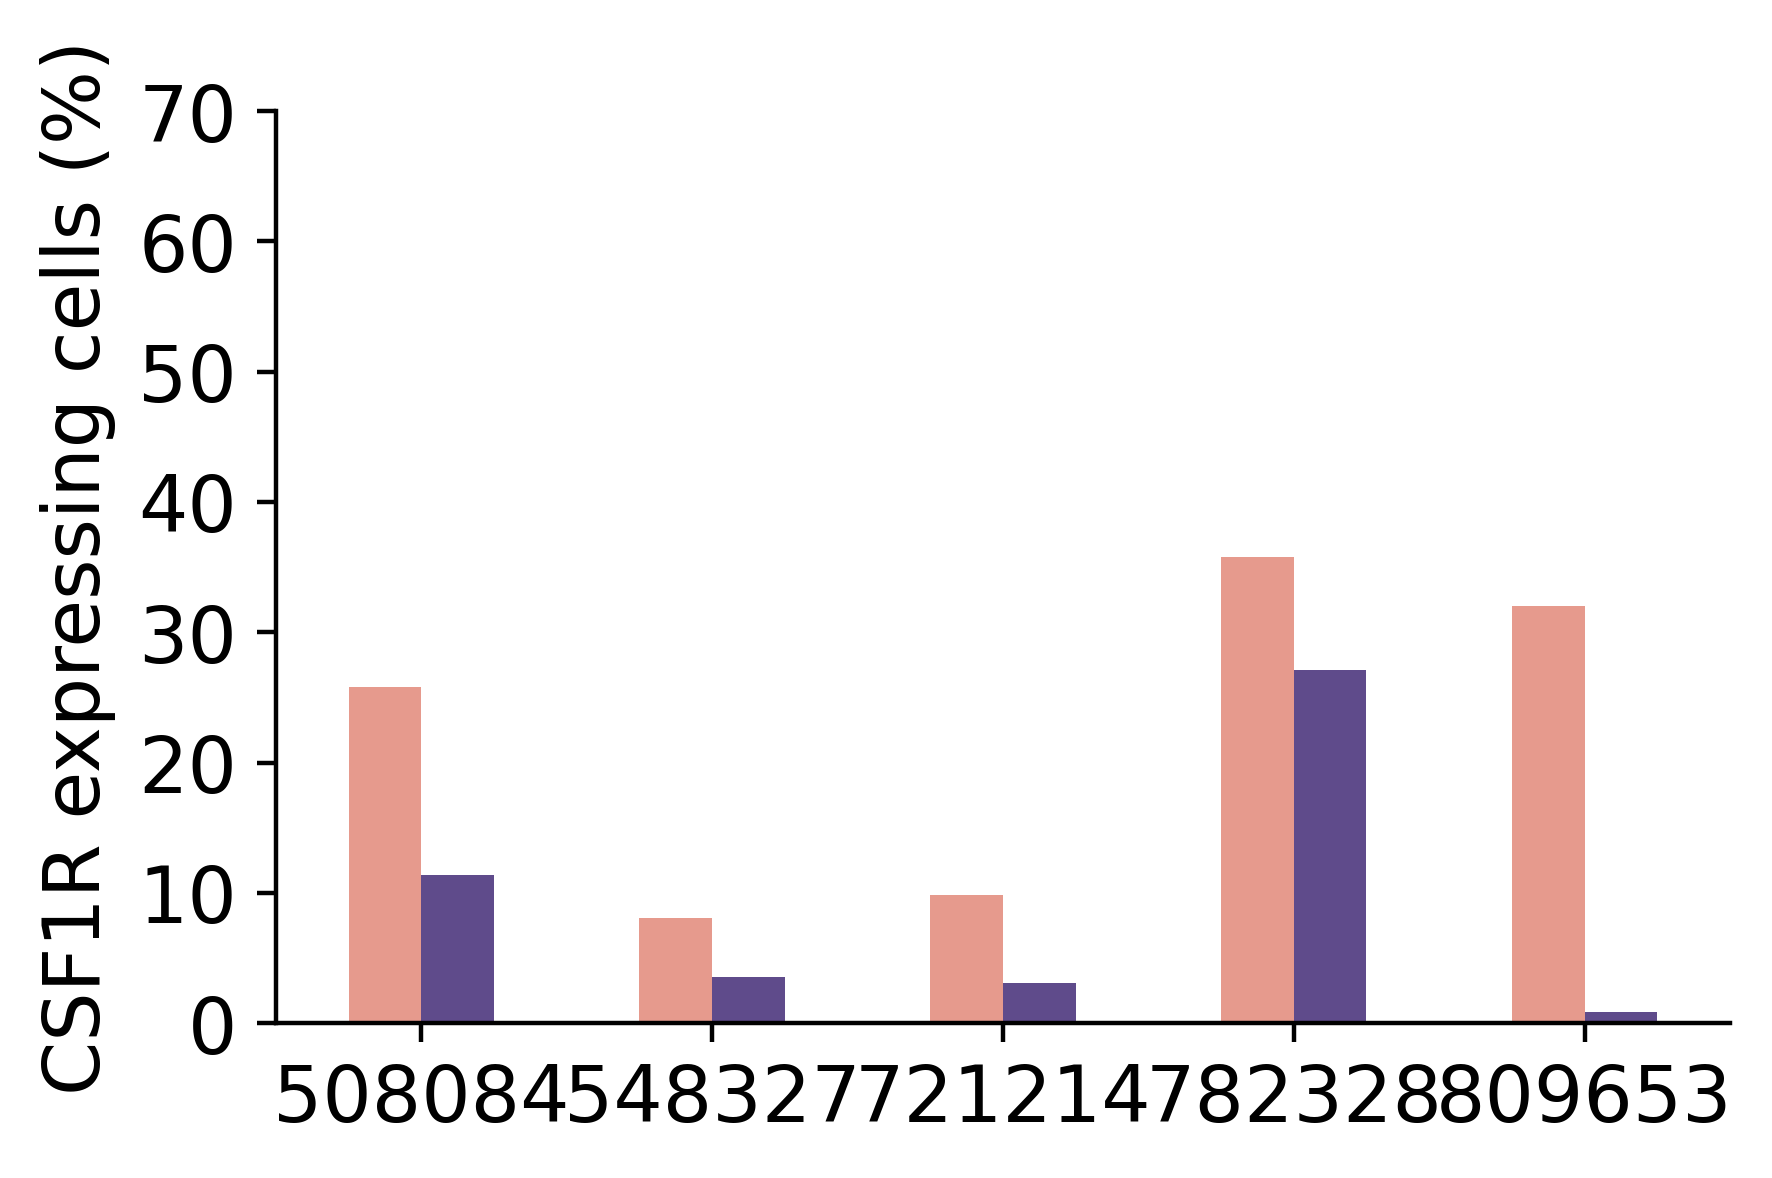

In [65]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(4.66,3))
ax=df1.plot(x='patient',
            kind='bar',
            width=0.5, 
               ax=ax,
            stacked=False,
            color=['#E69A8DFF','#5F4B8BFF'],
            title='')
plt.ylabel('CSF1R expressing cells (%)', size = 14)
plt.xlabel('', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid()
ax.yaxis.grid()

ax.set_ylim([0, 70])
plt.yticks([0,10,20,30,40,50,60,70])

ax.get_legend().remove()
#plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.25), ncol=2, prop={'size': 14})

plt.xticks(rotation=0)
#plt.tick_params(axis='x',which='both',bottom=False,top=False, labelbottom=False)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '508084'),
  Text(1, 0, '548327'),
  Text(2, 0, '721214'),
  Text(3, 0, '782328'),
  Text(4, 0, '809653')])

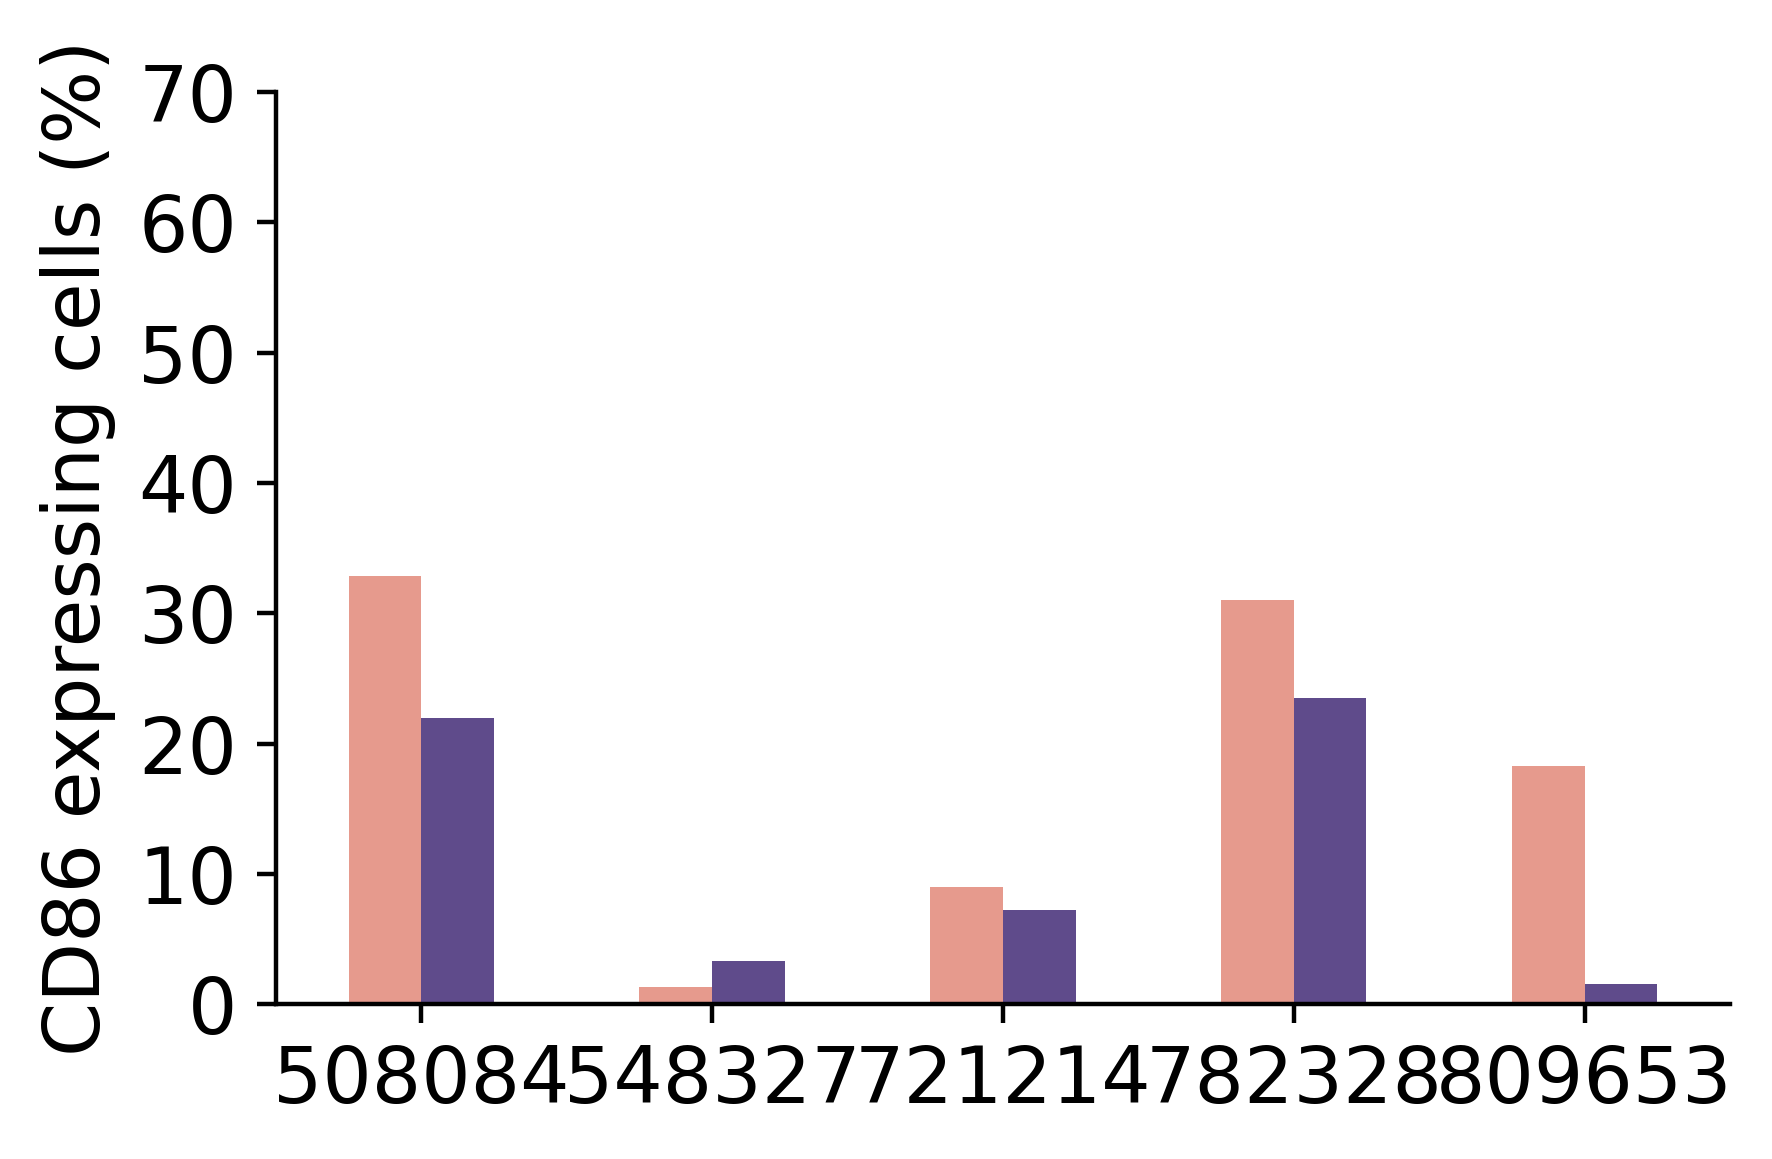

In [66]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(4.66,3))
ax=df2.plot(x='patient',
            kind='bar',
            width=0.5, 
               ax=ax,
            stacked=False,
            color=['#E69A8DFF','#5F4B8BFF'],
            title='')
plt.ylabel('CD86 expressing cells (%)', size = 14)
plt.xlabel('', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid()
ax.yaxis.grid()

ax.set_ylim([0, 70])
plt.yticks([0,10,20,30,40,50,60,70])

ax.get_legend().remove()
#plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.25), ncol=2, prop={'size': 14})

plt.xticks(rotation=0)
#plt.tick_params(axis='x',which='both',bottom=False,top=False, labelbottom=False)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '508084'),
  Text(1, 0, '548327'),
  Text(2, 0, '721214'),
  Text(3, 0, '782328'),
  Text(4, 0, '809653')])

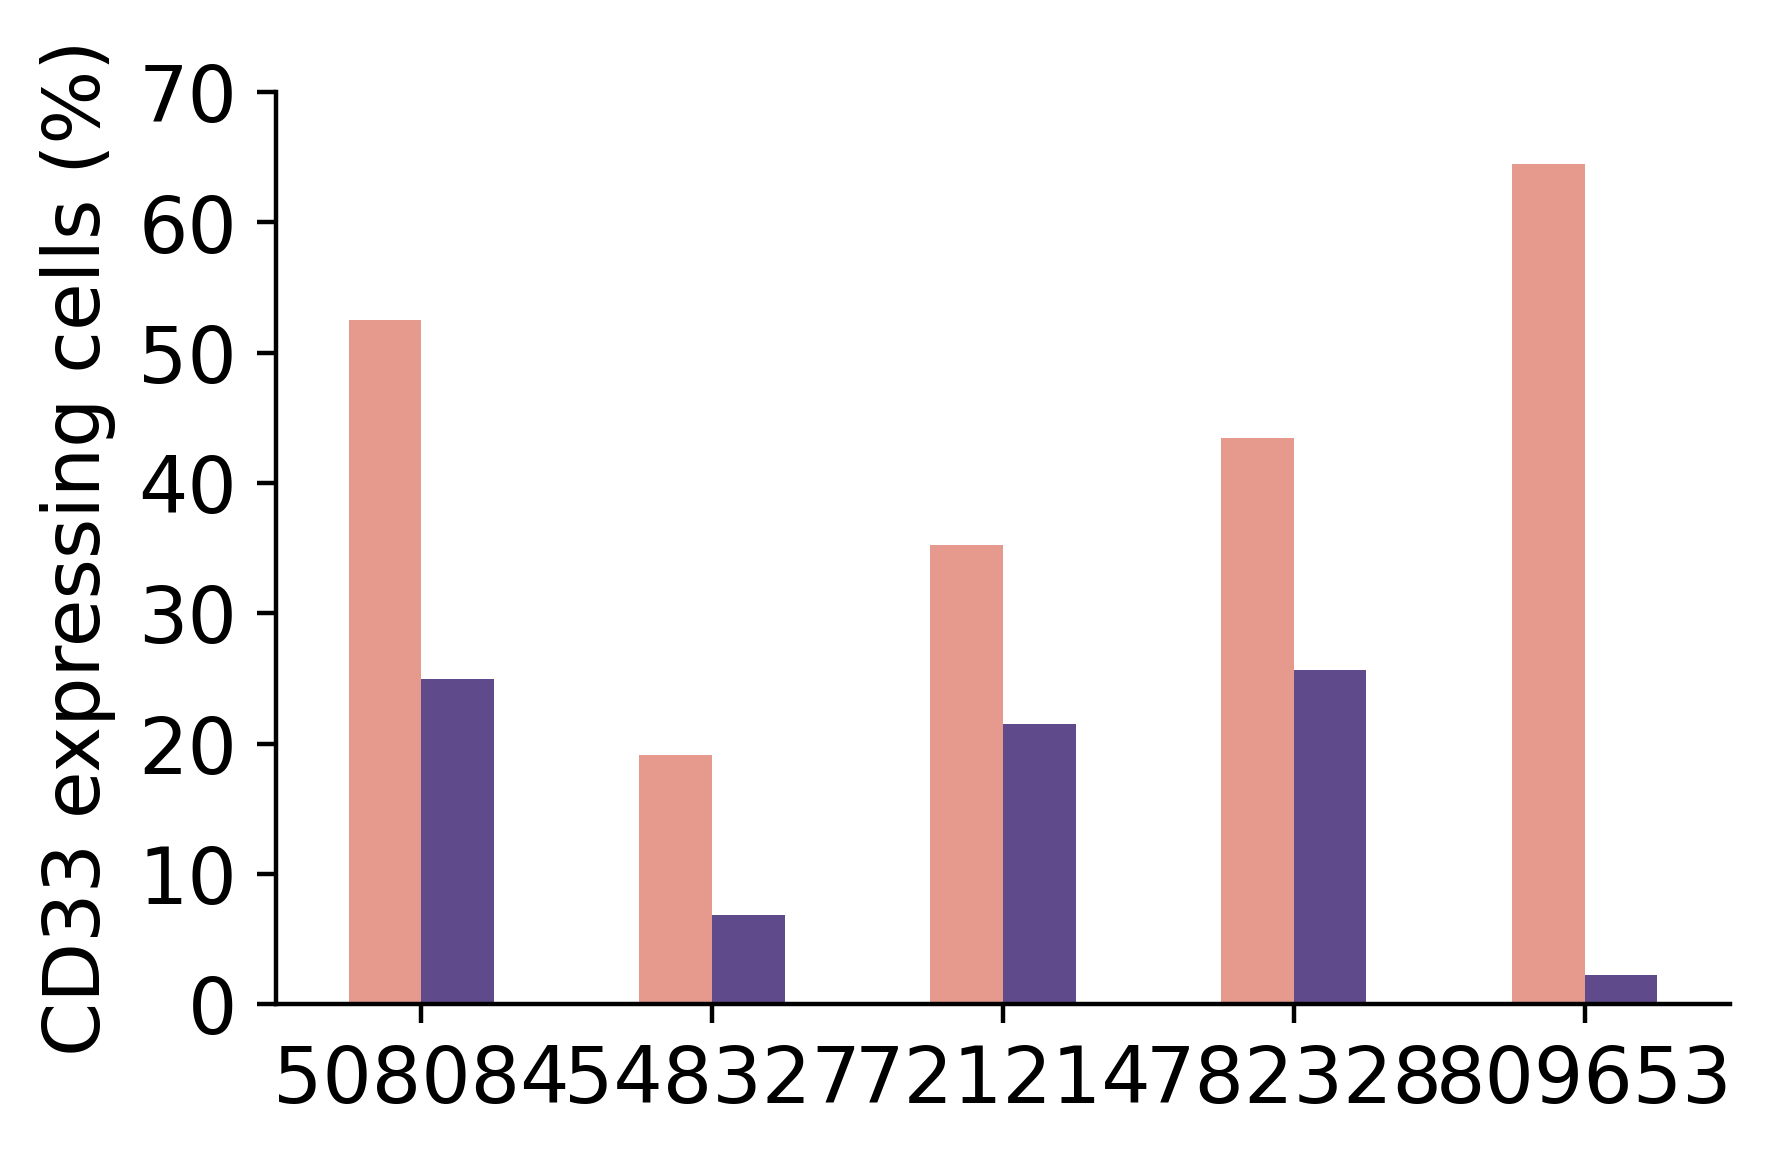

In [67]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(4.66,3))
ax=df3.plot(x='patient',
            kind='bar',
            width=0.5, 
               ax=ax,
            stacked=False,
            color=['#E69A8DFF','#5F4B8BFF'],
            title='')
plt.ylabel('CD33 expressing cells (%)', size = 14)
plt.xlabel('', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid()
ax.yaxis.grid()
ax.set_ylim([0, 70])
plt.yticks([0,10,20,30,40,50,60,70])

ax.get_legend().remove()
#plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.25), ncol=2, prop={'size': 14})


plt.xticks(rotation=0)

#plt.tick_params(axis='x',which='both',bottom=False,top=False, labelbottom=False)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '508084'),
  Text(1, 0, '548327'),
  Text(2, 0, '721214'),
  Text(3, 0, '782328'),
  Text(4, 0, '809653')])

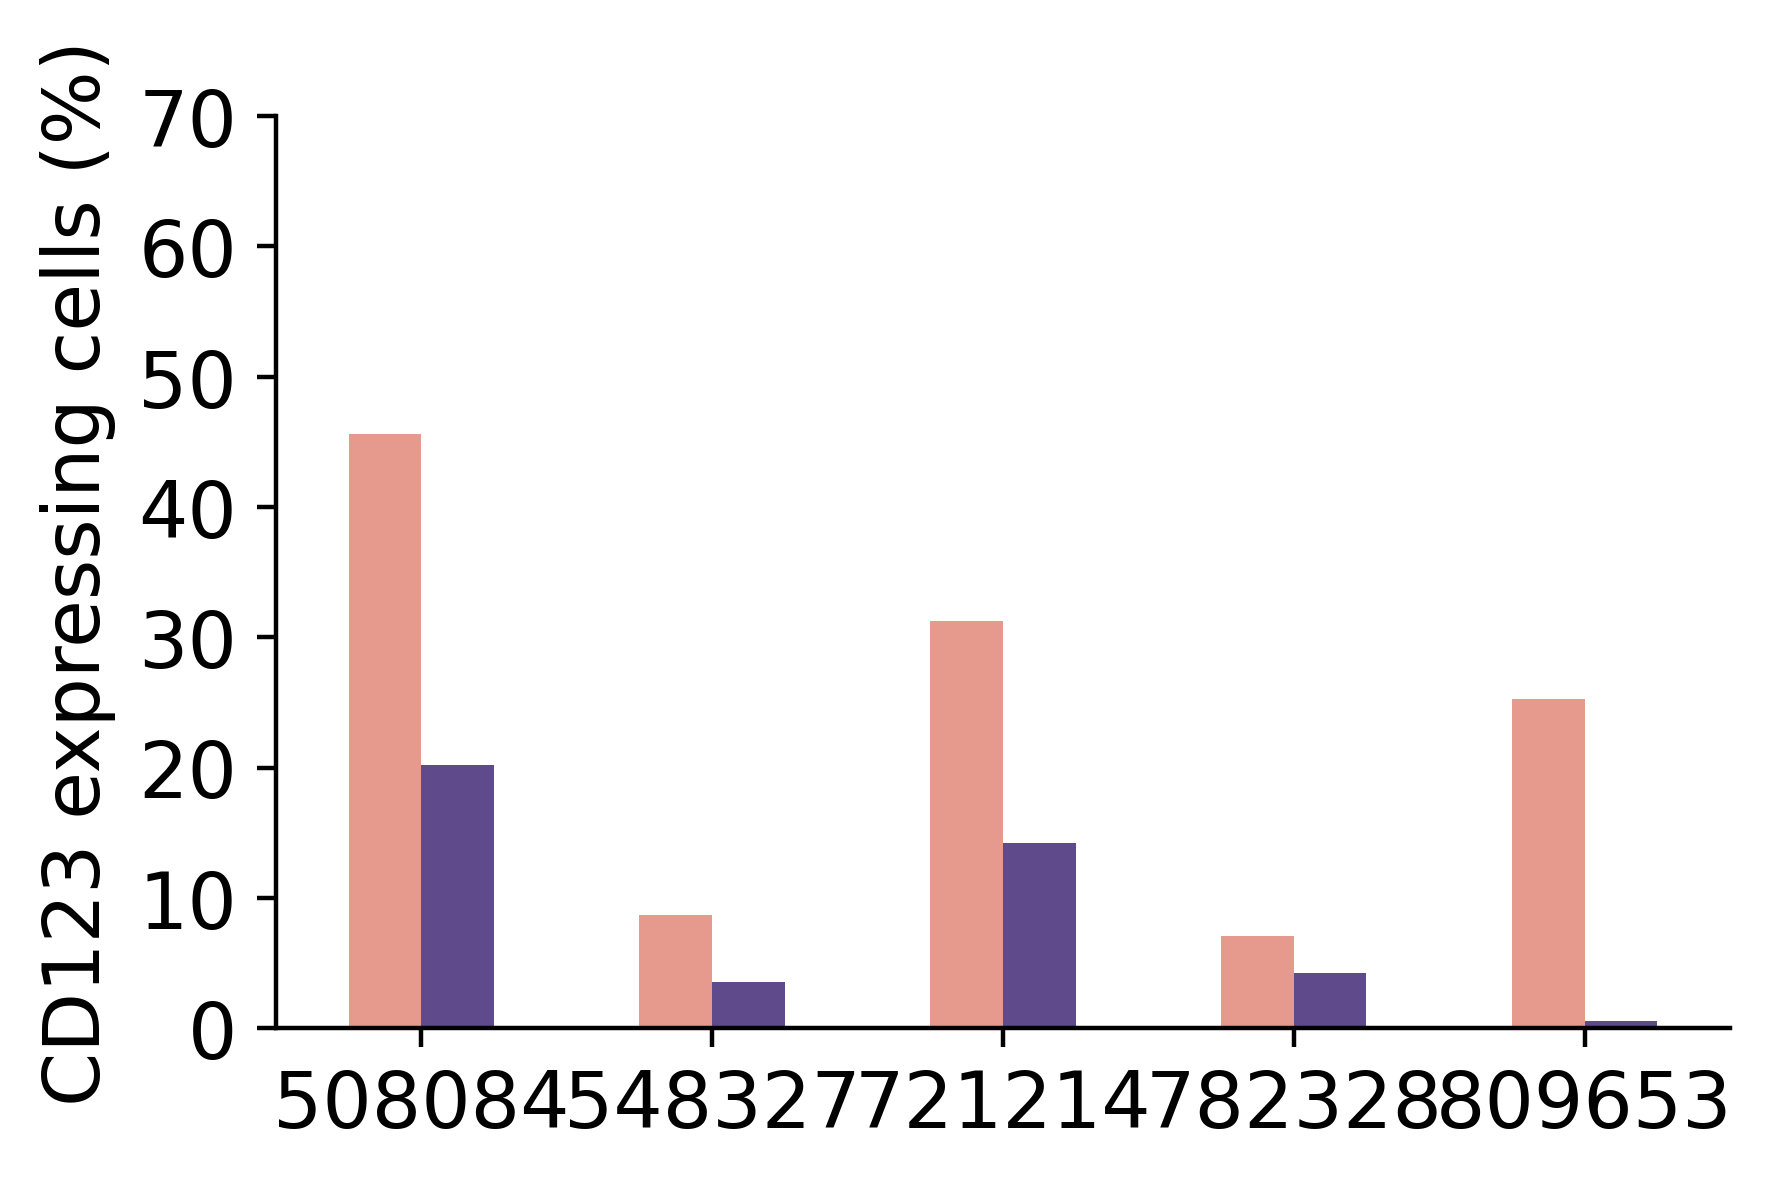

In [68]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(4.66,3))
ax=df4.plot(x='patient',
            kind='bar',
            width=0.5, 
               ax=ax,
            stacked=False,
            color=['#E69A8DFF','#5F4B8BFF'],
            title='')
plt.ylabel('CD123 expressing cells (%)', size = 14)
plt.xlabel('', size = 14)
plt.xticks(size = 14)
plt.yticks(size = 14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.grid()
ax.yaxis.grid()

ax.set_ylim([0, 70])
plt.yticks([0,10,20,30,40,50,60,70])

ax.get_legend().remove()
#plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.25), ncol=2, prop={'size': 14})


plt.xticks(rotation=0)

#plt.tick_params(axis='x',which='both',bottom=False,top=False, labelbottom=False)

# Target identification analysis on mapped Petti data

## Differential expression

In [262]:
goi=['CSF1R','CD86','IL3RA','CD33']

### HSC

In [249]:
# subset to only HSCs
ix=np.isin(adata.obs['cell_type_final'],['HSC', 'HSC-like']) 
adata_HSC=adata[ix].copy()

In [250]:
adata_HSC

AnnData object with n_obs × n_vars = 16178 × 17434
    obs: 'study', 'cell_type', 'predictions', 'condition', 'batch', 'dataset', 'cell_type_final'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'cell_type_final', 'cell_type_final_colors', 'dataset_colors', 'neighbors', 'predictions', 'predictions_colors', 'study_colors', 'tsne', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [251]:
sc.pp.calculate_qc_metrics(adata_HSC, inplace=True)

In [252]:
# filter out poorly expressed genes for differential expression analysis
sc.pp.filter_genes(adata_HSC, min_cells=5)

filtered out 3432 genes that are detected in less than 5 cells


In [253]:
# filter out genes that are expressed in more than 4000 counts for differential expression analysis
sc.pp.filter_genes(adata_HSC, max_cells=4000)

filtered out 2872 genes that are detected in more than 4000 cells


In [254]:
np.isin(['CSF1R','CD86','IL3RA','CD33'],adata.var.index)

array([ True,  True,  True,  True])

In [255]:
adata_HSC.obs['cell_type_final'].value_counts()

HSC-like    12664
HSC          3514
Name: cell_type_final, dtype: int64

In [256]:
sc.pp.log1p(adata_HSC)

In [257]:
# perform differential expression analysis
sc.tl.rank_genes_groups(adata_HSC, groupby='cell_type_final', method='wilcoxon',
                        n_genes=len(adata_HSC.var), key_added='testing')

ranking genes
    finished: added to `.uns['testing']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:12)


In [258]:
df_HSC=pd.DataFrame(adata_HSC.uns['testing']['names'])

tmp=np.array(pd.DataFrame(adata_HSC.uns['testing']['pvals'])['HSC-like'])
df_HSC['malignant_pval']=tmp

tmp=np.array(pd.DataFrame(adata_HSC.uns['testing']['pvals'])['HSC'])
df_HSC['normal_pval']=tmp

tmp=np.array(pd.DataFrame(adata_HSC.uns['testing']['logfoldchanges'])['HSC-like'])
df_HSC['malignant_logfoldchanges']=tmp

tmp=np.array(pd.DataFrame(adata_HSC.uns['testing']['logfoldchanges'])['HSC'])
df_HSC['normal_logfoldchanges']=tmp

In [263]:
np.isin(goi,df_HSC['HSC-like'])

array([ True,  True, False, False])

In [ ]:
# filter out genes that have a malignant_pval under 0.05
df_HSC_filtered=df_HSC[df_HSC['malignant_pval'] <= 0.05]
# filter out genes that have a malignant_logfoldchanges over 0
df_HSC_filtered=df_HSC_filtered[df_HSC_filtered['malignant_logfoldchanges'] > 0]

In [266]:
df_HSC_filtered.to_csv(writepath + 'HSC_genes_petti.csv')

### Prog

In [267]:
# subset to HPCs
ix=np.isin(adata.obs['cell_type_final'],['Prog', 'Prog-like']) 
adata_Prog=adata[ix].copy()

In [268]:
adata_Prog

AnnData object with n_obs × n_vars = 10641 × 17434
    obs: 'study', 'cell_type', 'predictions', 'condition', 'batch', 'dataset', 'cell_type_final'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'cell_type_final', 'cell_type_final_colors', 'dataset_colors', 'neighbors', 'predictions', 'predictions_colors', 'study_colors', 'tsne', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [269]:
sc.pp.calculate_qc_metrics(adata_Prog, inplace=True)

In [270]:
# filter out poorly expressed genes for differential expression analysis
sc.pp.filter_genes(adata_Prog, min_cells=5)

filtered out 3355 genes that are detected in less than 5 cells


In [271]:
# filter out genes that are expressed in more than 2000 counts for differential expression analysis
sc.pp.filter_genes(adata_Prog, max_cells=8000)

filtered out 637 genes that are detected in more than 8000 cells


In [272]:
sc.pp.log1p(adata_Prog)

In [273]:
# perform differential expression analysis
sc.tl.rank_genes_groups(adata_Prog, groupby='cell_type_final', method='wilcoxon',
                        n_genes=len(adata_HSC.var), key_added='testing')

ranking genes
    finished: added to `.uns['testing']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


In [274]:
df_HPC=pd.DataFrame(adata_Prog.uns['testing']['names'])

tmp=np.array(pd.DataFrame(adata_Prog.uns['testing']['pvals'])['Prog-like'])
df_HPC['malignant_pval']=tmp

tmp=np.array(pd.DataFrame(adata_Prog.uns['testing']['pvals'])['Prog'])
df_HPC['normal_pval']=tmp

tmp=np.array(pd.DataFrame(adata_Prog.uns['testing']['logfoldchanges'])['Prog-like'])
df_HPC['malignant_logfoldchanges']=tmp

tmp=np.array(pd.DataFrame(adata_Prog.uns['testing']['logfoldchanges'])['Prog'])
df_HPC['normal_logfoldchanges']=tmp

In [275]:
np.isin(['CSF1R','CD86','IL3RA','CD33'],df_HPC['Prog-like'])

array([ True,  True,  True,  True])

In [ ]:
# filter out genes that have a malignant_pval under 0.05
df_HPC_filtered=df_HPC[df_HPC['malignant_pval'] <= 0.05]
# filter out genes that have a malignant_logfoldchanges over 0
df_HPC_filtered=df_HPC_filtered[df_HPC_filtered['malignant_logfoldchanges'] > 0]

In [ ]:
df_HPC_filtered.to_csv(writepath + 'HPC_genes_petti.csv')

## Filter genes according to surface and T cell expression

In [517]:
HSC_genes=pd.read_csv(writepath + 'HSC_genes_petti.csv')
HPC_genes=pd.read_csv(writepath + 'HPC_genes_petti.csv')

In [ ]:
HSC_genes=np.array(HSC_genes['HSC-like'])
HPC_genes=np.array(HPC_genes['Prog-like'])

In [528]:
# overexpressed HSPC genes (intersection)
from functools import reduce
goi=reduce(np.intersect1d, (HSC_genes, HPC_genes))
len(goi)

2909

In [520]:
#read in surface genes (see other notebook)
surface=pd.read_csv(writepath + 'CellPhoneDB_CSPA_Surfaceome_HPA.csv')
surface=np.array(surface['CellPhoneDB_CSPA_Surfaceome_HPA'])
len(surface)

4924

In [529]:
# surface coding
from functools import reduce
goi=reduce(np.intersect1d, (goi, surface))
len(goi)

477

In [522]:
# t cell filtering (see other notebook)
tgenes=pd.read_csv(writepath + 'healthy_T_genes.csv')
tgenes=np.array(tgenes['T'])
len(tgenes)

1006

In [533]:
goi=goi[np.isin(goi,tgenes, invert=True)]
len(goi)

443

## Filter according to CrossOrganAtlas and druggable genes

In [ ]:
#read in all datasets

#Brain
adata_habib=sc.read(writepath + 'habib2017_human_processed.h5ad')

print('Brain datasets complete')

#Lung
adata_travaglini=sc.read(writepath + 'travaglini2020_processed.h5ad')

adata_madissoon_lung=sc.read(writepath + 'madissoon2020_lung_processed.h5ad')

adata_reyfman=sc.read(writepath + 'reyfman2019_processed.h5ad')

adata_kim=sc.read(writepath + 'kim2020_lung_processed.h5ad')

print('Lung datasets complete')

#Lymph nodes
adata_kim_ln=sc.read(writepath + 'kim2020_lymphnodes_processed.h5ad')

print('Lymph nodes datasets complete')

#Liver
adata_macparland=sc.read(writepath + 'macparland2018_processed.h5ad')

adata_ramachandran=sc.read(writepath + 'ramachandran2019_processed.h5ad')

print('Liver datasets complete')

#Kidney
adata_steward=sc.read(writepath + 'steward2019_processed.h5ad')

print('Kidney datasets complete')

#Gut
adata_james=sc.read(writepath + 'james2020_processed.h5ad')

adata_madissoon_colon=sc.read(writepath + 'madissoon2019_colon_processed.h5ad')

print('Gut datasets complete')

#Skin
adata_cheng=sc.read(writepath + 'cheng2018_processed.h5ad')

print('Skin datasets complete')

#Heart
adata_han=sc.read(writepath + 'han2020_processed.h5ad')

print('Heart datasets complete')

In [351]:
# concatenate datasets
adata = adata_habib.concatenate(adata_travaglini, adata_madissoon_lung, adata_reyfman, adata_kim, adata_kim_ln,
                                adata_macparland, adata_ramachandran, adata_steward, adata_james, 
                                adata_madissoon_colon, adata_cheng, adata_han, join='outer')

/home/moritz.thomas/.local/lib/python3.8/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/home/moritz.thomas/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [352]:
# remove irrelevant .obs
del adata.obs['BCR_CLONE']
del adata.obs['BCR_ChainCombination']
del adata.obs['BCR_ISOTYPE']
del adata.obs['BCR_PANDONOR_CLONE']
del adata.obs['BCR_SEQUENCE_ID']
del adata.obs['Celltypes']
del adata.obs['Donor']
del adata.obs['IGH_D_CALL']
del adata.obs['IGH_J_CALL']
del adata.obs['IGH_MU_FREQ']
del adata.obs['IGH_READS']
del adata.obs['IGH_UMIS']
del adata.obs['IGH_V_CALL_GENOTYPED']
del adata.obs['IGK_READS']
del adata.obs['IGK_UMIS']
del adata.obs['IGL_C_Gene']
del adata.obs['IGL_READS']
del adata.obs['IGL_UMIS']
del adata.obs['IGL_VDJ_Gene']
del adata.obs['Re-annotation']
del adata.obs['TCR_Clone']
del adata.obs['TCR_c_gene']
del adata.obs['TCR_cdr3']
del adata.obs['TCR_cdr3_nt']
del adata.obs['TCR_d_gene']
del adata.obs['TCR_j_gene']
del adata.obs['TCR_reads']
del adata.obs['TCR_umis']
del adata.obs['TCR_v_gene']
del adata.obs['Time']
del adata.obs['aetiology']
del adata.obs['ann_level_1']
del adata.obs['ann_level_2']
del adata.obs['ann_level_3']
del adata.obs['annotation_indepth']
del adata.obs['annotation_lineage']
del adata.obs['annotation_original']
del adata.obs['batch']
del adata.obs['broad_celltype']
del adata.obs['cell subtype']
del adata.obs['cell type']
del adata.obs['cell type refined']
del adata.obs['cell_ontology_class']
del adata.obs['cell_ontology_class_broad']
del adata.obs['cell_ontology_id']
del adata.obs['cell_type']
del adata.obs['celltype']
del adata.obs['celltype_global']
del adata.obs['celltype_specific']
del adata.obs['compartment']
del adata.obs['compl']
del adata.obs['condition']
del adata.obs['dataset']
del adata.obs['donor']
del adata.obs['donor_time']
del adata.obs['healthy']
del adata.obs['ident']
del adata.obs['last_author/PI']
del adata.obs['leiden']
del adata.obs['liver']
del adata.obs['log10_total_counts']
del adata.obs['log1p_n_counts']
del adata.obs['log1p_n_genes']
del adata.obs['log1p_n_genes_by_counts']
del adata.obs['log1p_total_counts']
del adata.obs['log_counts']
del adata.obs['mito_frac']
del adata.obs['mt_frac']
del adata.obs['nGene']
del adata.obs['nUMI']
del adata.obs['n_counts']
del adata.obs['n_genes']
del adata.obs['n_genes_by_counts']
del adata.obs['n_genes_detected']
del adata.obs['organ']
del adata.obs['origin']
del adata.obs['original_celltype_ann']
del adata.obs['patient']
del adata.obs['pct_counts_in_top_100_genes']
del adata.obs['pct_counts_in_top_200_genes']
del adata.obs['pct_counts_in_top_500_genes']
del adata.obs['pct_counts_in_top_50_genes']
del adata.obs['percent.mito']
del adata.obs['percent_hb']
del adata.obs['percent_mito']
del adata.obs['percent_ribo']
del adata.obs['percent_top50']
del adata.obs['region']
del adata.obs['ribo_frac']
del adata.obs['sample']
del adata.obs['size_factors']
del adata.obs['state_exact']
del adata.obs['tissue']
del adata.obs['total_counts']
del adata.obs['CellType']

In [524]:
genes=np.array(adata.var.index)
genes

array(['A1BG', 'A1BG-AS1', 'A1CF', ..., 'ZZZ3', 'bP-21264C1.2',
       'bP-2189O9.3'], dtype=object)

In [525]:
del adata.var

In [526]:
del adata.obsm

In [527]:
adata

AnnData object with n_obs × n_vars = 531582 × 33443
    obs: 'CellType_Atlas', 'S_score', 'G2M_score', 'phase', 'barcode'
    layers: 'counts', 'logcounts'

In [535]:
len(goi)

443

In [536]:
adata_goi=adata[:,goi].copy()

In [537]:
adata_goi

AnnData object with n_obs × n_vars = 531582 × 443
    obs: 'CellType_Atlas', 'S_score', 'G2M_score', 'phase', 'barcode'
    layers: 'counts', 'logcounts'

In [538]:
adata_goi.strings_to_categoricals()

... storing 'CellType_Atlas' as categorical
... storing 'phase' as categorical
... storing 'barcode' as categorical


In [539]:
adata_goi.obs['CellType_Atlas'].cat.categories

Index(['Alveolar', 'Arterial', 'Astrocytes', 'B cells', 'Basal', 'Bronchial',
       'Capillary', 'Cardiomyocyte', 'Dendritics', 'Endothelial', 'Epithelial',
       'Erythroid', 'Fibroblasts', 'Glands', 'Hepatic stellate', 'Hepatocytes',
       'Innate Lymphoid', 'Interneurons', 'Keratinocytes', 'Loop of Henle',
       'Lymphoid', 'Macrophages', 'Mast', 'Megakaryocytes', 'Melanocyte',
       'Mesenchymal', 'Mesothelial', 'Microglia', 'Monocytes', 'Multiciliated',
       'NK cells', 'Neuronal stem cells', 'Neurons', 'Neutrophils',
       'Oligodendrocytes', 'Podocytes', 'Proximal Tubule', 'Remove',
       'Secretory', 'Smooth muscle', 'Stroma', 'T cells', 'Unknown', 'Venous'],
      dtype='object')

In [540]:
# only include relevant celltypes
ix=np.isin(adata_goi.obs['CellType_Atlas'],['Alveolar', 'Arterial', 'Astrocytes', 'B cells', 'Basal', 'Bronchial',
       'Capillary', 'Cardiomyocyte', 'Dendritics', 'Endothelial', 'Epithelial',
       'Erythroid', 'Fibroblasts', 'Glands', 'Hepatic stellate', 'Hepatocytes',
       'Innate Lymphoid', 'Interneurons', 'Keratinocytes', 'Loop of Henle',
       'Lymphoid', 'Macrophages', 'Mast', 'Megakaryocytes', 'Melanocyte',
       'Mesenchymal', 'Mesothelial', 'Microglia', 'Monocytes', 'Multiciliated',
       'NK cells', 'Neuronal stem cells', 'Neurons', 'Neutrophils',
       'Oligodendrocytes', 'Podocytes', 'Proximal Tubule',
       'Secretory', 'Smooth muscle', 'Stroma', 'T cells',  'Venous']) 
adata_goi=adata_goi[ix].copy()

In [541]:
order = ('Endothelial', 'Epithelial', 'Mesenchymal', 'Mesothelial','Stroma','Erythroid', 'Fibroblasts',
         'Innate Lymphoid', 'Lymphoid','Monocytes','Macrophages','Dendritics', 'Mast', 'Megakaryocytes', 
         'B cells', 'T cells','NK cells','Multiciliated','Neutrophils','Secretory','Astrocytes', 'Interneurons',  
         'Neurons', 'Microglia', 'Neuronal stem cells', 'Oligodendrocytes','Alveolar', 'Arterial','Bronchial',
         'Capillary', 'Venous','Smooth muscle','Cardiomyocyte','Basal',  'Keratinocytes', 'Melanocyte','Glands', 
         'Hepatic stellate', 'Hepatocytes','Loop of Henle', 'Podocytes','Proximal Tubule')

adata_goi.obs['CellType_Atlas']=adata_goi.obs['CellType_Atlas'].cat.reorder_categories(list(order), ordered=True)

In [545]:
sc.set_figure_params(vector_friendly=True, color_map='Reds',
                     dpi=100,transparent=True, fontsize=4)

In [547]:
# only critical cells
ix=np.isin(adata_goi.obs['CellType_Atlas'],['Endothelial','Arterial','Bronchial','Capillary','Venous',
                                             'Smooth muscle','Podocytes']) 
adata_goi_critical=adata_goi[ix].copy()

In [553]:
df=pd.DataFrame(columns=['Endothelial','Arterial','Bronchial','Capillary','Venous','Smooth muscle'], 
                    index=goi)

In [550]:
adata_goi.X=sp.sparse.csr_matrix.todense(adata_goi.X)


In [551]:
# calculate how many cells of one celltype express GOI

In [554]:
# Endothelial

# reduce to celltype
ix=np.isin(adata_goi.obs['CellType_Atlas'],['Endothelial']) 
adata_tmp=adata_goi[ix].copy()

In [555]:
matrix=pd.DataFrame(adata_tmp.X)
matrix.columns=goi

In [556]:
percentages_endo=[]

In [557]:
for gene in matrix.columns:
    matrix_tmp=matrix[gene]
    overall=(len(matrix_tmp))
    express_goi=(len(matrix_tmp[matrix_tmp>0]))
    percent=100*express_goi/overall
    percentages_endo.append(percent)

In [558]:
df['Endothelial']=percentages_endo

In [559]:
# Arterial

# reduce to celltype
ix=np.isin(adata_goi.obs['CellType_Atlas'],['Arterial']) 
adata_tmp=adata_goi[ix].copy()

In [560]:
matrix=pd.DataFrame(adata_tmp.X)
matrix.columns=goi
percentages_tmp=[]

In [561]:
for gene in matrix.columns:
    matrix_tmp=matrix[gene]
    overall=(len(matrix_tmp))
    express_goi=(len(matrix_tmp[matrix_tmp>0]))
    percent=100*express_goi/overall
    percentages_tmp.append(percent)

In [562]:
df['Arterial']=percentages_tmp

In [563]:
# Bronchial

# reduce to celltype
ix=np.isin(adata_goi.obs['CellType_Atlas'],['Bronchial']) 
adata_tmp=adata_goi[ix].copy()

In [564]:
matrix=pd.DataFrame(adata_tmp.X)
matrix.columns=goi
percentages_tmp=[]

In [565]:
for gene in matrix.columns:
    matrix_tmp=matrix[gene]
    overall=(len(matrix_tmp))
    express_goi=(len(matrix_tmp[matrix_tmp>0]))
    percent=100*express_goi/overall
    percentages_tmp.append(percent)

In [566]:
df['Bronchial']=percentages_tmp


In [567]:
# Capillary

# reduce to celltype
ix=np.isin(adata_goi.obs['CellType_Atlas'],['Capillary']) 
adata_tmp=adata_goi[ix].copy()

In [568]:
matrix=pd.DataFrame(adata_tmp.X)
matrix.columns=goi
percentages_tmp=[]

In [569]:
for gene in matrix.columns:
    matrix_tmp=matrix[gene]
    overall=(len(matrix_tmp))
    express_goi=(len(matrix_tmp[matrix_tmp>0]))
    percent=100*express_goi/overall
    percentages_tmp.append(percent)

In [570]:
df['Capillary']=percentages_tmp

In [571]:
# Venous

# reduce to celltype
ix=np.isin(adata_goi.obs['CellType_Atlas'],['Venous']) 
adata_tmp=adata_goi[ix].copy()

In [572]:
matrix=pd.DataFrame(adata_tmp.X)
matrix.columns=goi
percentages_tmp=[]

In [573]:
for gene in matrix.columns:
    matrix_tmp=matrix[gene]
    overall=(len(matrix_tmp))
    express_goi=(len(matrix_tmp[matrix_tmp>0]))
    percent=100*express_goi/overall
    percentages_tmp.append(percent)

In [574]:
df['Venous']=percentages_tmp

In [575]:
# Smooth muscle

# reduce to celltype
ix=np.isin(adata_goi.obs['CellType_Atlas'],['Smooth muscle']) 
adata_tmp=adata_goi[ix].copy()

In [576]:
matrix=pd.DataFrame(adata_tmp.X)
matrix.columns=goi
percentages_tmp=[]

In [577]:
for gene in matrix.columns:
    matrix_tmp=matrix[gene]
    overall=(len(matrix_tmp))
    express_goi=(len(matrix_tmp[matrix_tmp>0]))
    percent=100*express_goi/overall
    percentages_tmp.append(percent)

In [578]:
df['Smooth muscle']=percentages_tmp

In [580]:
df['thresholds_passed']=df.apply(lambda row: sum([(x < 2) for x in row]), axis = 1)

In [584]:
len(df.columns)-1

6

In [ ]:
final_candidates=df[df['thresholds_passed']==len(df.columns)-1]

In [ ]:
final_candidates=final_candidates.index

In [591]:
len(final_candidates)

42

In [ ]:
# Druggable filter

In [588]:
#read in druggable genes
druggable=pd.read_csv(writepath + 'druggable_proteome_genes.csv')
druggable=np.array(druggable['druggable_proteome_genes'])
len(druggable)

754

In [592]:
from functools import reduce
final_candidates=reduce(np.intersect1d, (final_candidates, druggable))
len(final_candidates)

5

In [593]:
final_candidates

array(['CD86', 'CSF1R', 'CSF2RA', 'FCGR1A', 'ITGAL'], dtype=object)